# AI-tofocus - Distance-To-Focus Classifier - 3 Classes

In [1]:
%matplotlib inline

import cv2
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model, layers, models

from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import Iterator, ImageDataGenerator

from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import Iterator, ImageDataGenerator
import tensorflow.keras.backend as K

print(tf.__version__)
print(tf.test.is_built_with_cuda()) 
print(tf.config.list_physical_devices('GPU'))
import shutil
import skimage.transform

import napari

plt.style.use('ggplot')

2.2.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


C:\Users\Lab513\AppData\Roaming\Python\Python38\site-packages\napari\_qt\__init__.py:38: UserWarning: napari was tested with QT library `>=5.12.3`.
The version installed is 5.9.7. Please report any issues with this specific QT version at https://github.com/Napari/napari/issues.
  warn(message=warn_message)


# 1. Load images and corresponding distance to focal plane

In [2]:
class ImageClassificationGenerator(Sequence):
    """
    Generates images and masks for performing data augmentation in Keras.
    We inherit from Sequence (instead of directly using the keras ImageDataGenerator)
    since we want to perform augmentation on both the input image AND the mask 
    (target). This mechanism needs to be implemented in this class. This class
    also allows to implement new augmentation transforms that are not implemented
    in the core Keras class (illumination, etc.).
    See : https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    and https://stackoverflow.com/questions/56758592/how-to-customize-imagedatagenerator-in-order-to-modify-the-target-variable-value
    for more details.
    """

    def __init__(self, X_set, metadata, target_label="z", # input images and metadata containing the labels
                 n_channels_ims=1,
                 shuffle=False,
                 batch_size: int=64, dim: tuple=(32, 32),
                 n_channels: int=1, # informations 
                 normalize=True, reshape=False, crop=None, # preprocessing params
                 restrict_to="", augmentation_params=None): # data augmentation params
        """
        X_set (list, array or str): pointer to the images (Bright-Field). If str, the string is assumed to be pointing at some directory.
        metadata (pd.DataFrame): DF containing any metadata, with the targets and the file_names
        target_label (str): name of the column containing the target in the metadata dataframe
        batch_size (int): size of the batch
        dim (tuple): dimension of the images
        n_channels (int) : number of channels of the images (1 for TIF)
        shuffle (bool): Shuffle the dataset between each training epoch
        normalize (bool): normalize the images and masks in the beginning
        reshape (bool): reshape the images and masks to (dim, dim, n_channels)
        histogram_equalization (bool): perform histogram equalization to improve
        rendering using opencv
        horiz_flip_percent ()
        vert_flip_percent
        """
        # super().__init__(n, batch_size, shuffle, seed)
        self.dim = dim
        self.im_size = dim
        self.batch_size = batch_size
        self.n_channels_ims = n_channels
        self.reshape = reshape
        self.crop = crop

        self.shuffle = shuffle
        
        self.restrict_to = restrict_to

        # build the X_set in an array. If X_set is a directory containing images
        # then self.X_set doesn't contains the images but the file names, but it
        # is transparent for the user.
        if type(X_set) == list:
            self.from_directory_X = False
            self.X_set = np.array(X_set)
        elif type(X_set) == np.array:
            self.from_directory_X = False
            self.X_set = X_set           
        elif type(X_set) == str: # assuming a path
            self.from_directory_X = True
            self.X_dir = X_set # path to the images dir
            self.X_set = []
            if self.restrict_to == "":
                for k in range(0, len(os.listdir(X_set)), self.n_channels_ims):
                    self.X_set.append(np.array(os.listdir(X_set)[k:k+self.n_channels_ims]))
                self.X_set = np.array(self.X_set)
            else:
                for k in range(0, len(os.listdir(X_set)), self.n_channels_ims):
                    if os.listdir(X_set)[k].startswith(self.restrict_to):
                        self.X_set.append(np.array(os.listdir(X_set)[k:k+self.n_channels_ims]))
                self.X_set = np.array(self.X_set)
        else:
            raise TypeError("X_set should be list, array or path")

        # Preprocessing parameters
        self.normalize = normalize
        
        # CLassification
        self.metadata = metadata
        self.target_label = target_label
        
        # The Keras generator that will be used to perform data augmentation 
        self.augmentation_params = augmentation_params
        if self.augmentation_params is not None:
            self.generator = ImageDataGenerator(**self.augmentation_params)
        
        # one hot encoding of the three labels
        self.trinarize = np.vectorize(lambda x: np.array([1, 0, 0]) if x > 0 else (np.array([0, 1, 0]) if x < 0 else np.array([0, 0, 1])))

        # Initialize the indices (shuffle if asked)
        self.on_epoch_end()

    def __len__(self) -> int:
        """
        Number of batches per epoch : we evenly split the train set into samples
        of size batch_size.
        """
        return int(np.floor(self.X_set.shape[0] / self.batch_size))

    def __getitem__(self, index: int):
        """
        Generate one batch of data.
        """
        if index >= self.__len__():
            raise IndexError
            
        # Generate indices corresponding to the images in the batch
        indices = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate the batch
        X = self.__data_generation(indices)
        return X        

    def on_epoch_end(self):
        """
        Updates indexes after each epoch. self.indexes is used to retrieve the
        samples and organize them into batches.
        If shuffle : randomizes the order of the samples in order to give 
        different training batches at each epoch.
        """
        self.indexes = np.arange(self.X_set.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs: [int]):
        """
        Generates data containing batch_size samples. This is where we load the
        images if they are in a directory, and apply transformations to them.
        """ 
        # Load data (from directory or from X_set depending on the given data)
        if self.from_directory_X:
            batch_X = []
            for im in list_IDs:
                channels = []
                for k in range(self.n_channels_ims):  # in case of several channels per image
                    channels.append(np.expand_dims(imageio.imread(f"{self.X_dir}/{self.X_set[im, k]}"), axis=-1)) # add channel axis
                batch_X.append(np.concatenate(channels, axis=-1))
            batch_X = np.array(batch_X)            
        else:
            batch_X = self.X_set[list_IDs]
        
        # generate labels from the metadata dataframe : retrieve the row with the right filename and takes the corresponding target
        batch_Y = []
        for im in list_IDs:
            label = self.metadata[self.metadata["file_name"] == self.X_set[im][0]][self.target_label].values[0]
            batch_Y.append(self.trinarize(label))
        batch_Y = np.array(batch_Y)  # binary label
        
        # preprocessing
        if self.normalize:
            batch_X = self.perf_normalize(batch_X)
            
        if self.reshape:
            batch_X = self.perf_reshape(batch_X)
            
        if self.crop:
            batch_X = self.perf_crop(batch_X)
            
        # Perform the SAME transformation on the image and on the mask
        if self.augmentation_params is not None:
            for i, img in enumerate(batch_X):
                transform_params = self.generator.get_random_transform(img.shape)
                batch_X[i] = self.generator.apply_transform(img, transform_params)

        return batch_X, batch_Y

    def perf_normalize(self, images):
        """
        Performs per image, per channel normalization by substracting the min and dividing by (max - min)
        """
        new_batch = np.empty(images.shape)
        for i, img in enumerate(images):
            assert (np.min(img, axis=(0, 1)) != np.max(img, axis=(0, 1))).all(), print("Cannot normalize an image containing only 0 or 1 valued pixels. There is likely an empty image in the training set.\nIf cropping was used,"
                                                                                       "maybe the mask doesn't contain any white pixel in the specific region.")
            new_batch[i] = (img - np.min(img, axis=(0, 1))) / (np.max(img, axis=(0, 1)) - np.min(img, axis=(0, 1)))
        return new_batch
    
    def perf_reshape(self, images):
        """
        images (np.array): batch of images of shape (batch_size, n_rows, n_cols, n_chans)
        is_images (bool): is it a batch of images (True) or masks (False)
        """
        new_batch = np.empty((self.batch_size, *self.im_size, self.n_channels_ims))
        for i, img in enumerate(images): # the resize function normalizes the images anyways...
            new_batch[i] = skimage.transform.resize(img, (*self.im_size, self.n_channels_ims), anti_aliasing=True)
        return new_batch
    
    def perf_crop(self, images):
        crop_X = int((images.shape[1] - self.crop[0]) // 2)
        crop_Y = int((images.shape[2] - self.crop[1]) // 2)
        assert (crop_X >= 0 and crop_Y >= 0), print(f"Target size after cropping {self.crop} should be lower than the initial shape {(images.shape[1], images.shape[2])}.")
        new_batch = np.empty((self.batch_size, *self.crop, images.shape[3]))
        for i, img in enumerate(images):
            if crop_X != 0 and crop_Y != 0:
                new_batch[i] = img[crop_X:-crop_X, crop_Y:-crop_Y]
            elif crop_X != 0:
                new_batch[i] = img[crop_X:-crop_X, :]
            elif crop_Y != 0:
                new_batch[i] = img[:, crop_Y:-crop_Y]
            else:
                new_batch[i] = img
        return new_batch

In [3]:
# Make validation set out of the train set
train_set_path, validation_set_path, test_set_path = "D:\Hugo\Autofocus\Classification/Train_Set/", "D:\Hugo\Autofocus/Classification/Validation_Set/", "D:\Hugo\Autofocus\Classification/Test_Set/"
train_metadata, val_metadata, test_metadata = pd.read_csv("D:\Hugo\Autofocus/Classification/train_set_table.csv", sep=","), pd.read_csv("D:\Hugo\Autofocus/Classification/validation_set_table.csv", sep=","), pd.read_csv("D:\Hugo\Autofocus/Classification/test_set_table.csv", sep=",")

restrict_to = ""
bat_size, nc_ims = 22, 1 # SPECIFY HERE THE NUMBER OF CHANNELS
target_dim, reshape, normalize, crop = (256, 256), True, True, None
augmentation_params = augmentation_params = dict(zoom_range=[0.9, 1.2],
                           rotation_range=360,
                           height_shift_range=0.1,
                           width_shift_range=0.1,
                           fill_mode="constant", cval=0)

train_set = ImageClassificationGenerator(train_set_path, train_metadata, target_label="z", batch_size=bat_size, dim=target_dim, n_channels_ims=nc_ims, 
                         normalize=normalize, restrict_to=restrict_to, shuffle=True, reshape=reshape, augmentation_params=augmentation_params, crop=crop)

validation_set = ImageClassificationGenerator(validation_set_path, val_metadata, target_label="z", batch_size=bat_size, dim=target_dim, n_channels_ims=nc_ims, 
                         normalize=normalize, restrict_to=restrict_to, shuffle=False, reshape=reshape, crop=crop)

test_set = ImageClassificationGenerator(test_set_path, test_metadata, target_label="z", batch_size=32, dim=target_dim, n_channels_ims=nc_ims, 
                          normalize=normalize, restrict_to=restrict_to, shuffle=False, reshape=reshape, crop=crop)

def visualize_data(bf, nc_ims=1):
    viewer = napari.Viewer()
    if nc_ims == 1:
        viewer.add_image(bf[:, :, :, :].squeeze(-1))
    else:
        viewer.add_image(bf[:, :, :, 0])  # bf
        for k in range(1, nc_ims):
            viewer.add_image(bf[:, :, :, k], blending="additive")
    napari.run()

plot = True
if plot:
    print(f"# Batches : {len(train_set)}")
    bf, targets = train_set[0]
    print(bf.shape, targets.shape)
    print(targets)
    visualize_data(bf, nc_ims=nc_ims)

# Batches : 10
(22, 256, 256, 1) (22, 3)
[[0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]]


# 2. Train distance-to-focus (DTA) Classifier

In [4]:
from tensorflow.keras.applications import VGG19

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

def get_lenet(input_shape, plot_summary=False):
    lenet = keras.Sequential()

    lenet.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    lenet.add(layers.MaxPooling2D())

    lenet.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    lenet.add(layers.MaxPooling2D())
    
    lenet.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    lenet.add(layers.MaxPooling2D())
    
    lenet.add(layers.Flatten())

#     lenet.add(layers.Dense(units=256, activation='relu'))
    
    lenet.add(layers.Dense(units=128, activation='relu'))
    lenet.add(layers.Dropout(0.4))

    lenet.add(layers.Dense(units=64, activation='relu'))
    lenet.add(layers.Dropout(0.4))
    
    lenet.add(layers.Dense(units=32, activation='relu'))
    lenet.add(layers.Dropout(0.4))

    lenet.add(layers.Dense(units=1, activation = 'softmax'))
    
    if plot_summary:
        print(lenet.summary())
    
    return lenet

def get_VGG16(input_shape, plot_summary=False):    
    model = keras.Sequential()

    model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation='softmax'))
    
    if plot_summary:
        print(model.summary())

    return model

def get_AlexNet(input_shape, plot_summary=False):
    #Instantiation
    AlexNet = Sequential()

    #1st Convolutional Layer
    AlexNet.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11), strides=(4,4), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #2nd Convolutional Layer
    AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #3rd Convolutional Layer
    AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))

    #4th Convolutional Layer
    AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))

    #5th Convolutional Layer
    AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #Passing it to a Fully Connected layer
    AlexNet.add(Flatten())
    # 1st Fully Connected Layer
    AlexNet.add(Dense(4096))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    # Add Dropout to prevent overfitting
#     AlexNet.add(Dropout(0.2))

    #2nd Fully Connected Layer
    AlexNet.add(Dense(4096))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    #Add Dropout
#     AlexNet.add(Dropout(0.2))

    #3rd Fully Connected Layer
    AlexNet.add(Dense(1000))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    #Add Dropout
    AlexNet.add(Dropout(0.2))

    #Output Layer
    AlexNet.add(Dense(1))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('softmax'))

    #Model Summary
    if plot_summary:
        print(AlexNet.summary())
        
    return AlexNet

from keras.activations import relu
from tensorflow.keras.layers import *

class ResBlock(Model):
    def __init__(self, channels, stride=1, index="0"):
        super(ResBlock, self).__init__(name=f"ResBlock_{index}")
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same', name=f"conv_{index}_1")
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same', name=f"conv_{index}_2")
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride, name=f"conv_{index}_3")

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    def __init__(self, input_shape):
        super(ResNet34, self).__init__(name='ResNet34')
        self.input_dim = input_shape
                
        self.conv1 = Conv2D(64, 7, 2, padding='same', input_shape=input_shape)
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.mp1 = MaxPooling2D(3, 2)

        self.conv2_1 = ResBlock(64, index="21")
        self.conv2_2 = ResBlock(64, index="22")
        self.conv2_3 = ResBlock(64, index="23")

        self.conv3_1 = ResBlock(128, 2, index="31")
        self.conv3_2 = ResBlock(128, index="32")
        self.conv3_3 = ResBlock(128, index="33")
        self.conv3_4 = ResBlock(128, index="34")

        self.conv4_1 = ResBlock(256, 2, index="41")
        self.conv4_2 = ResBlock(256, index="42")
        self.conv4_3 = ResBlock(256, index="43")
        self.conv4_4 = ResBlock(256, index="44")
        self.conv4_5 = ResBlock(256, index="45")
        self.conv4_6 = ResBlock(256, index="46")

        self.conv5_1 = ResBlock(512, 2, index="51")
        self.conv5_2 = ResBlock(512, index="52")
        self.conv5_3 = ResBlock(512, index="53")

        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(512, activation='relu')
        self.dp1 = Dropout(0.5)
        self.fc2 = Dense(512, activation='relu')
        self.dp2 = Dropout(0.5)
        self.fc3 = Dense(3, activation="softmax")

    def call(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.mp1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.conv4_5(x)
        x = self.conv4_6(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)

        x = self.pool(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        return x

Using TensorFlow backend.


compiled model
Epoch 1/150
10/10 [==============================] - 11s 1s/step - loss: 1.0462 - accuracy: 0.5500 - val_loss: 1.0682 - val_accuracy: 0.4343 - lr: 5.0000e-05
Epoch 2/150
10/10 [==============================] - 7s 697ms/step - loss: 1.0075 - accuracy: 0.6091 - val_loss: 1.0456 - val_accuracy: 0.4343 - lr: 5.0000e-05
Epoch 3/150
10/10 [==============================] - 7s 697ms/step - loss: 1.0100 - accuracy: 0.6136 - val_loss: 1.0350 - val_accuracy: 0.4343 - lr: 5.0000e-05
Epoch 4/150
10/10 [==============================] - 7s 687ms/step - loss: 1.0055 - accuracy: 0.6227 - val_loss: 1.0377 - val_accuracy: 0.4343 - lr: 5.0000e-05
Epoch 5/150
10/10 [==============================] - 7s 686ms/step - loss: 0.9521 - accuracy: 0.5864 - val_loss: 1.0021 - val_accuracy: 0.4343 - lr: 5.0000e-05
Epoch 6/150
10/10 [==============================] - 7s 686ms/step - loss: 0.9199 - accuracy: 0.6182 - val_loss: 0.9976 - val_accuracy: 0.4343 - lr: 5.0000e-05
Epoch 7/150
10/10 [========

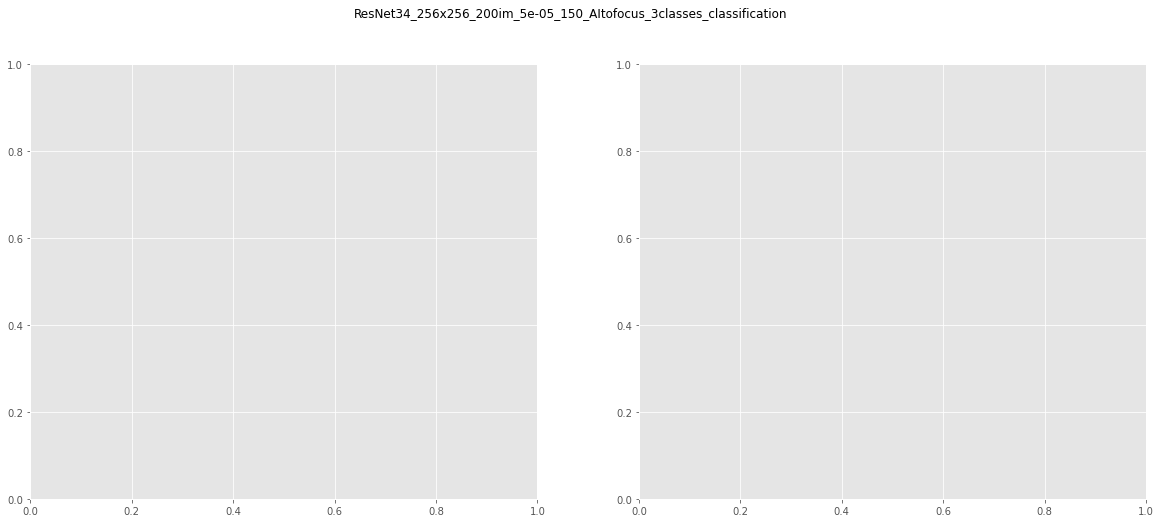

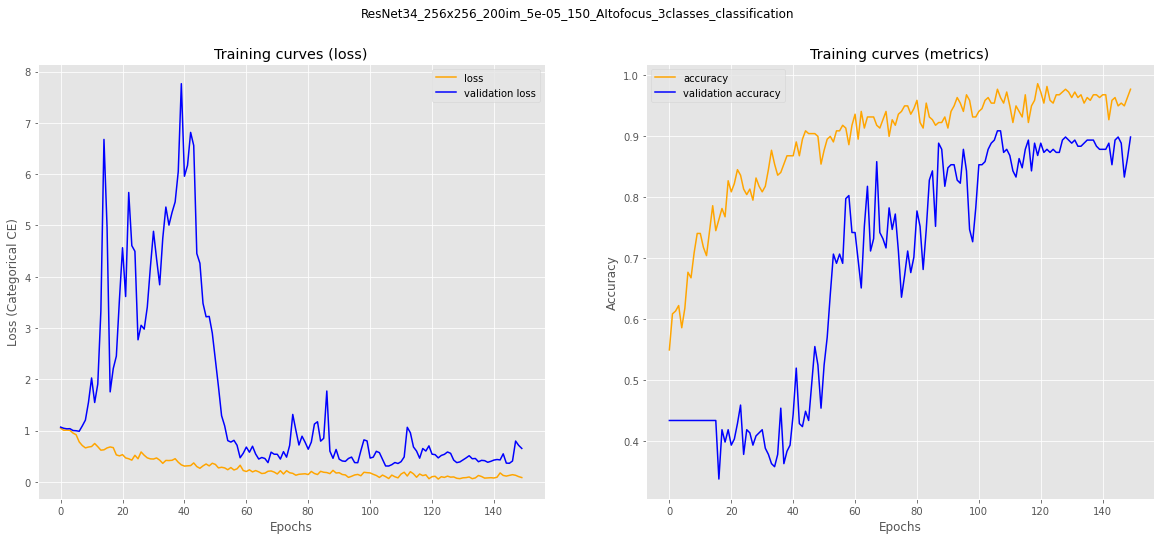

In [5]:
import io

save_path = f"D:\Hugo\Autofocus/Classification/Models/"
init_lr, n_epochs = 5e-5, 150
model_name = f"ResNet34_256x256_200im_{init_lr}_{n_epochs}_AItofocus_3classes_classification"

if os.path.isdir(f"{save_path}/{model_name}") and os.listdir(f"{save_path}/{model_name}") != []:
    raise ValueError("Model save path already exists. Would overwrite previously done work.")
elif os.path.isdir(f"{save_path}/{model_name}") and os.listdir(f"{save_path}/{model_name}") == []:
    shutil.rmtree(f"{save_path}/{model_name}")
os.mkdir(f"{save_path}/{model_name}")

lr_sched = lambda epoch, lr: lr / 2 if (epoch >= 50 and epoch % 50 == 0) else lr

callbacks = [# keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, verbose=1, patience=10, min_lr=1e-5),
             tf.keras.callbacks.LearningRateScheduler(lr_sched, verbose=0),]
#              keras.callbacks.ModelCheckpoint(f"{save_path}/checkpoint_AItofocus_{model_name}.hdf5", monitor="val_loss", save_best_only=True, verbose=0)]

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle(model_name)

# tta_classifier = get_lenet((target_dim[0], target_dim[1], nc_ims), plot_summary=True)
# tta_classifier = get_VGG16((target_dim[0], target_dim[1], nc_ims), plot_summary=True)
# tta_classifier = get_AlexNet((target_dim[0], target_dim[1], nc_ims), plot_summary=True)
tta_classifier = ResNet34((target_dim[0], target_dim[1], nc_ims))
    
tta_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=init_lr),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

print("compiled model")

history = tta_classifier.fit(train_set, validation_data=validation_set, 
                             epochs=n_epochs, verbose=1, callbacks=callbacks)
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle(model_name)
# plot learning curves
ax[0].plot(history.history["loss"][:], "orange", label="loss")
ax[0].plot(history.history["val_loss"][:], "b", label="validation loss")
ax[0].legend()
ax[0].set_title("Training curves (loss)")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel(f"Loss (Categorical CE)")

ax[1].plot(history.history["accuracy"][:], "orange", label="accuracy")
ax[1].plot(history.history["val_accuracy"][:], "b", label="validation accuracy")
ax[1].legend()
ax[1].set_title("Training curves (metrics)")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

# save model
if not os.path.isdir(save_path):
    os.mkdir(save_path)
tta_classifier.save(f"{save_path}/{model_name}")

plt.savefig(f"{save_path}/{model_name}/learning_curve.png")

list_training_imgs = "\n".join(os.listdir(train_set.X_dir))
n_params = tta_classifier.count_params()

with open(f"{save_path}/{model_name}/history.txt", "w") as hist_file:
    hist_file.write(f"Model {model_name} trained for {n_epochs} epochs."
                    f"\n\nInput shape : (batch, {target_dim[0]}, {target_dim[1]}, {nc_ims})"
                    f"\n\nNumber of parameters : {n_params}"
                    f"\n\nImages preprocessing:\nNormalize: {normalize}\Reshape: {reshape}\nTarget dimension: {target_dim}\nCrop images: {crop}."
                    f"\n\nNumber of training images : {len(train_set) * bat_size}, from directory {train_set.X_dir}"
                    f"\n\nNumber of validation images : {len(validation_set) * bat_size}"
                    f"\n\nLoss : BCE"
                    f"\n\nInitial learning rate: {init_lr}."
                    f"\n\nList of the training images:\n{list_training_imgs}."
                   )

In [17]:
print(tta_classifier.count_params())

21829761


# 3. DTA classifier evaluation

### Metrics calculation on test set

In [4]:
# tta_classifier = keras.models.load_model("D:\Hugo\Autofocus\Classification\Models/VGG16_256x256_200im_no_crop250_AItofocus_classification")

In [10]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

binarize = np.vectorize(lambda x: 1 if x > 0.4 else 0)

gt, predictions, predictions_bin = [], [], []
for i, batch in enumerate(test_set):
    ims, labels = batch
    preds = tta_classifier.predict(ims)
    preds_bin = binarize(preds)
#     preds = np.squeeze(tta_classifier.predict(ims), axis=-1)
    predictions_bin.extend([p for p in preds_bin])
    predictions.extend([p for p in preds])
    gt.extend([g for g in labels])
    
    print(labels[0], preds_bin[0], preds[0])
    
gt, predictions_bin = np.array(gt), np.array(predictions_bin)
prec, rec, acc = precision_score(gt, predictions_bin, average="micro"), recall_score(gt, predictions_bin, average="micro"), accuracy_score(gt, predictions_bin),
    
print(f"Precision on evaluation set = {prec}.")
print(f"Recall on evaluation set = {rec}.")
print(f"Accuracy on evaluation set = {acc}.")

Precision on evaluation set = 0.8715753424657534.
Recall on evaluation set = 0.8836805555555556.
Accuracy on evaluation set = 0.8715277777777778.


### Distribution of the scores, given the classes

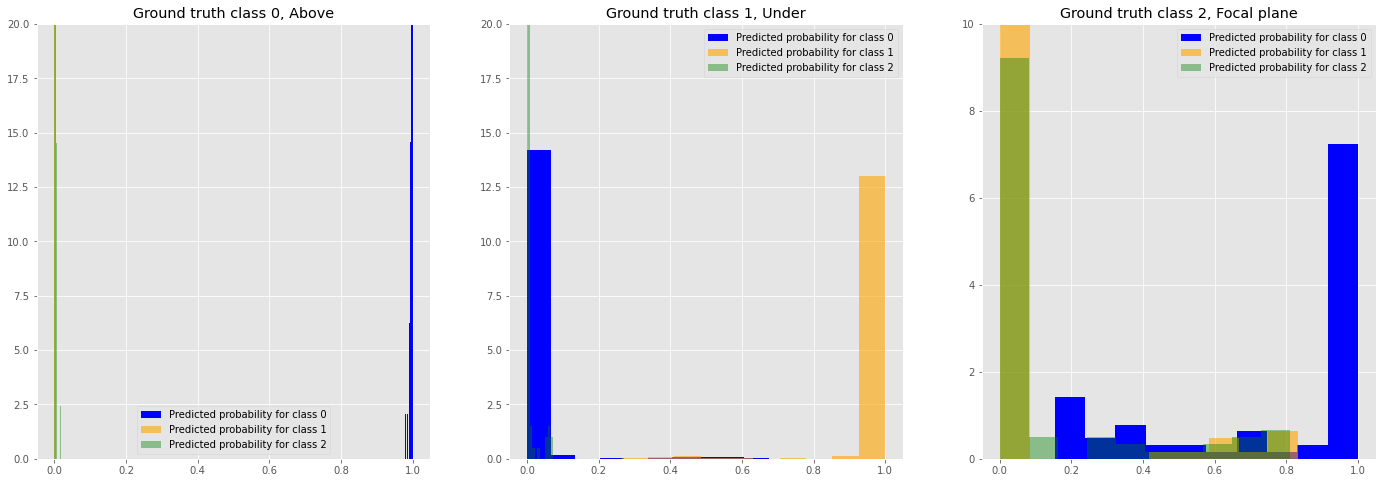

In [23]:
os.chdir("D:\Hugo\Autofocus\Classification\Models")

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

gt, predictions_zero, predictions_one, predictions_two = [], [], [], []
for i, batch in enumerate(test_set):
    ims, labels = batch
    preds = tta_classifier.predict(ims)
    
    for l, p in zip(labels, preds):

        if np.argwhere(l == 1)[0, 0] == 0:  # for each gt class, get the predicted probabilities
            predictions_zero.append(p)
        elif np.argwhere(l == 1)[0, 0] == 1:
            predictions_one.append(p)
        elif np.argwhere(l == 1)[0, 0] == 2:
            predictions_two.append(p)
predictions_zero, predictions_one, predictions_two = np.array(predictions_zero), np.array(predictions_one), np.array(predictions_two)

for i, (ax, preds, ymax, title) in enumerate(zip(axes, [predictions_zero, predictions_one, predictions_two], [20, 20, 10], ["Above", "Under", "Focal plane"])):
    ax.hist(preds[:, 0], color="blue", label="Predicted probability for class 0", density=True)
    ax.hist(preds[:, 1], color="orange", alpha=0.6, label="Predicted probability for class 1", density=True)
    ax.hist(preds[:, 2], color="green", alpha=0.4, label="Predicted probability for class 2", density=True)
    ax.set_ylim(0, ymax)
    ax.set_title(f"Ground truth class {i}, {title}")
    ax.legend()

plt.savefig(f"{model_name}/Test_set_evaluation_ResNet34_3classes.png", format="png")

### Plot the worst predictions

In [24]:
# fig, ax = plt.subplots(1, 10, figsize=(40, 4))

all_images, all_labels, all_predictions = [], [], []
for i, batch in enumerate(test_set):
    ims, labels = batch
    preds = np.squeeze(tta_classifier.predict(ims), axis=-1)

    for k, (i, l, p) in enumerate(zip(ims, labels, preds)):
        all_images.append(i)
        all_labels.append(l)
        all_predictions.append(p)
        
all_images, all_labels, all_predictions = np.array(all_images), np.array(all_labels), np.array(all_predictions)

worst_predictions_idx = np.argwhere((all_labels == 0) & (all_predictions >= 0.5))

fig, axes  = plt.subplots((worst_predictions_idx.shape[0] // 5) + 1, 5, figsize=(5 * 8, (worst_predictions_idx.shape[0] // 5 + 1) * 8))

for k, (idx, im, p, ax) in enumerate(zip(worst_predictions_idx, all_images[worst_predictions_idx], all_predictions[worst_predictions_idx], axes.flatten())):
    ax.imshow(np.squeeze(im, axis=(0, -1)), cmap="gray")
    ax.set_title(f"Image {idx}. Prediction: {p}")

ValueError: cannot select an axis to squeeze out which has size not equal to one

# 4.Activation maps

In [25]:
# tta_classifier = keras.models.load_model("D:\Hugo\Autofocus\Classification\Models/VGG16_256x256_200im_no_crop250_AItofocus_classification")
tta_classifier.summary()

Model: "ResNet34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  3200      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
ResBlock_21 (ResBlock)       multiple                  74368     
_________________________________________________________________
ResBlock_22 (ResBlock)       multiple                  74368     
_________________________________________________________________
ResBlock_23 (ResBlock)       multiple                  743

In [26]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    img_array = np.expand_dims(img_array, axis=0)
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    return heatmap.numpy()

import matplotlib.cm as cm
from IPython.display import Image, display

def save_and_display_gradcam(img, heatmap, axe, alpha=0.025):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")
    
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Display Grad CAM
    axe.imshow(np.squeeze(img, axis=-1), cmap="gray")
    axe.imshow(skimage.transform.resize(jet_heatmap, (img.shape[0], img.shape[1])), alpha=0.4)
    plt.colorbar(c)

(32, 256, 256, 1) (32, 3)
Visualizing Grad-CAM for batch 2.


AttributeError: Layer ResBlock_53 has no inbound nodes.

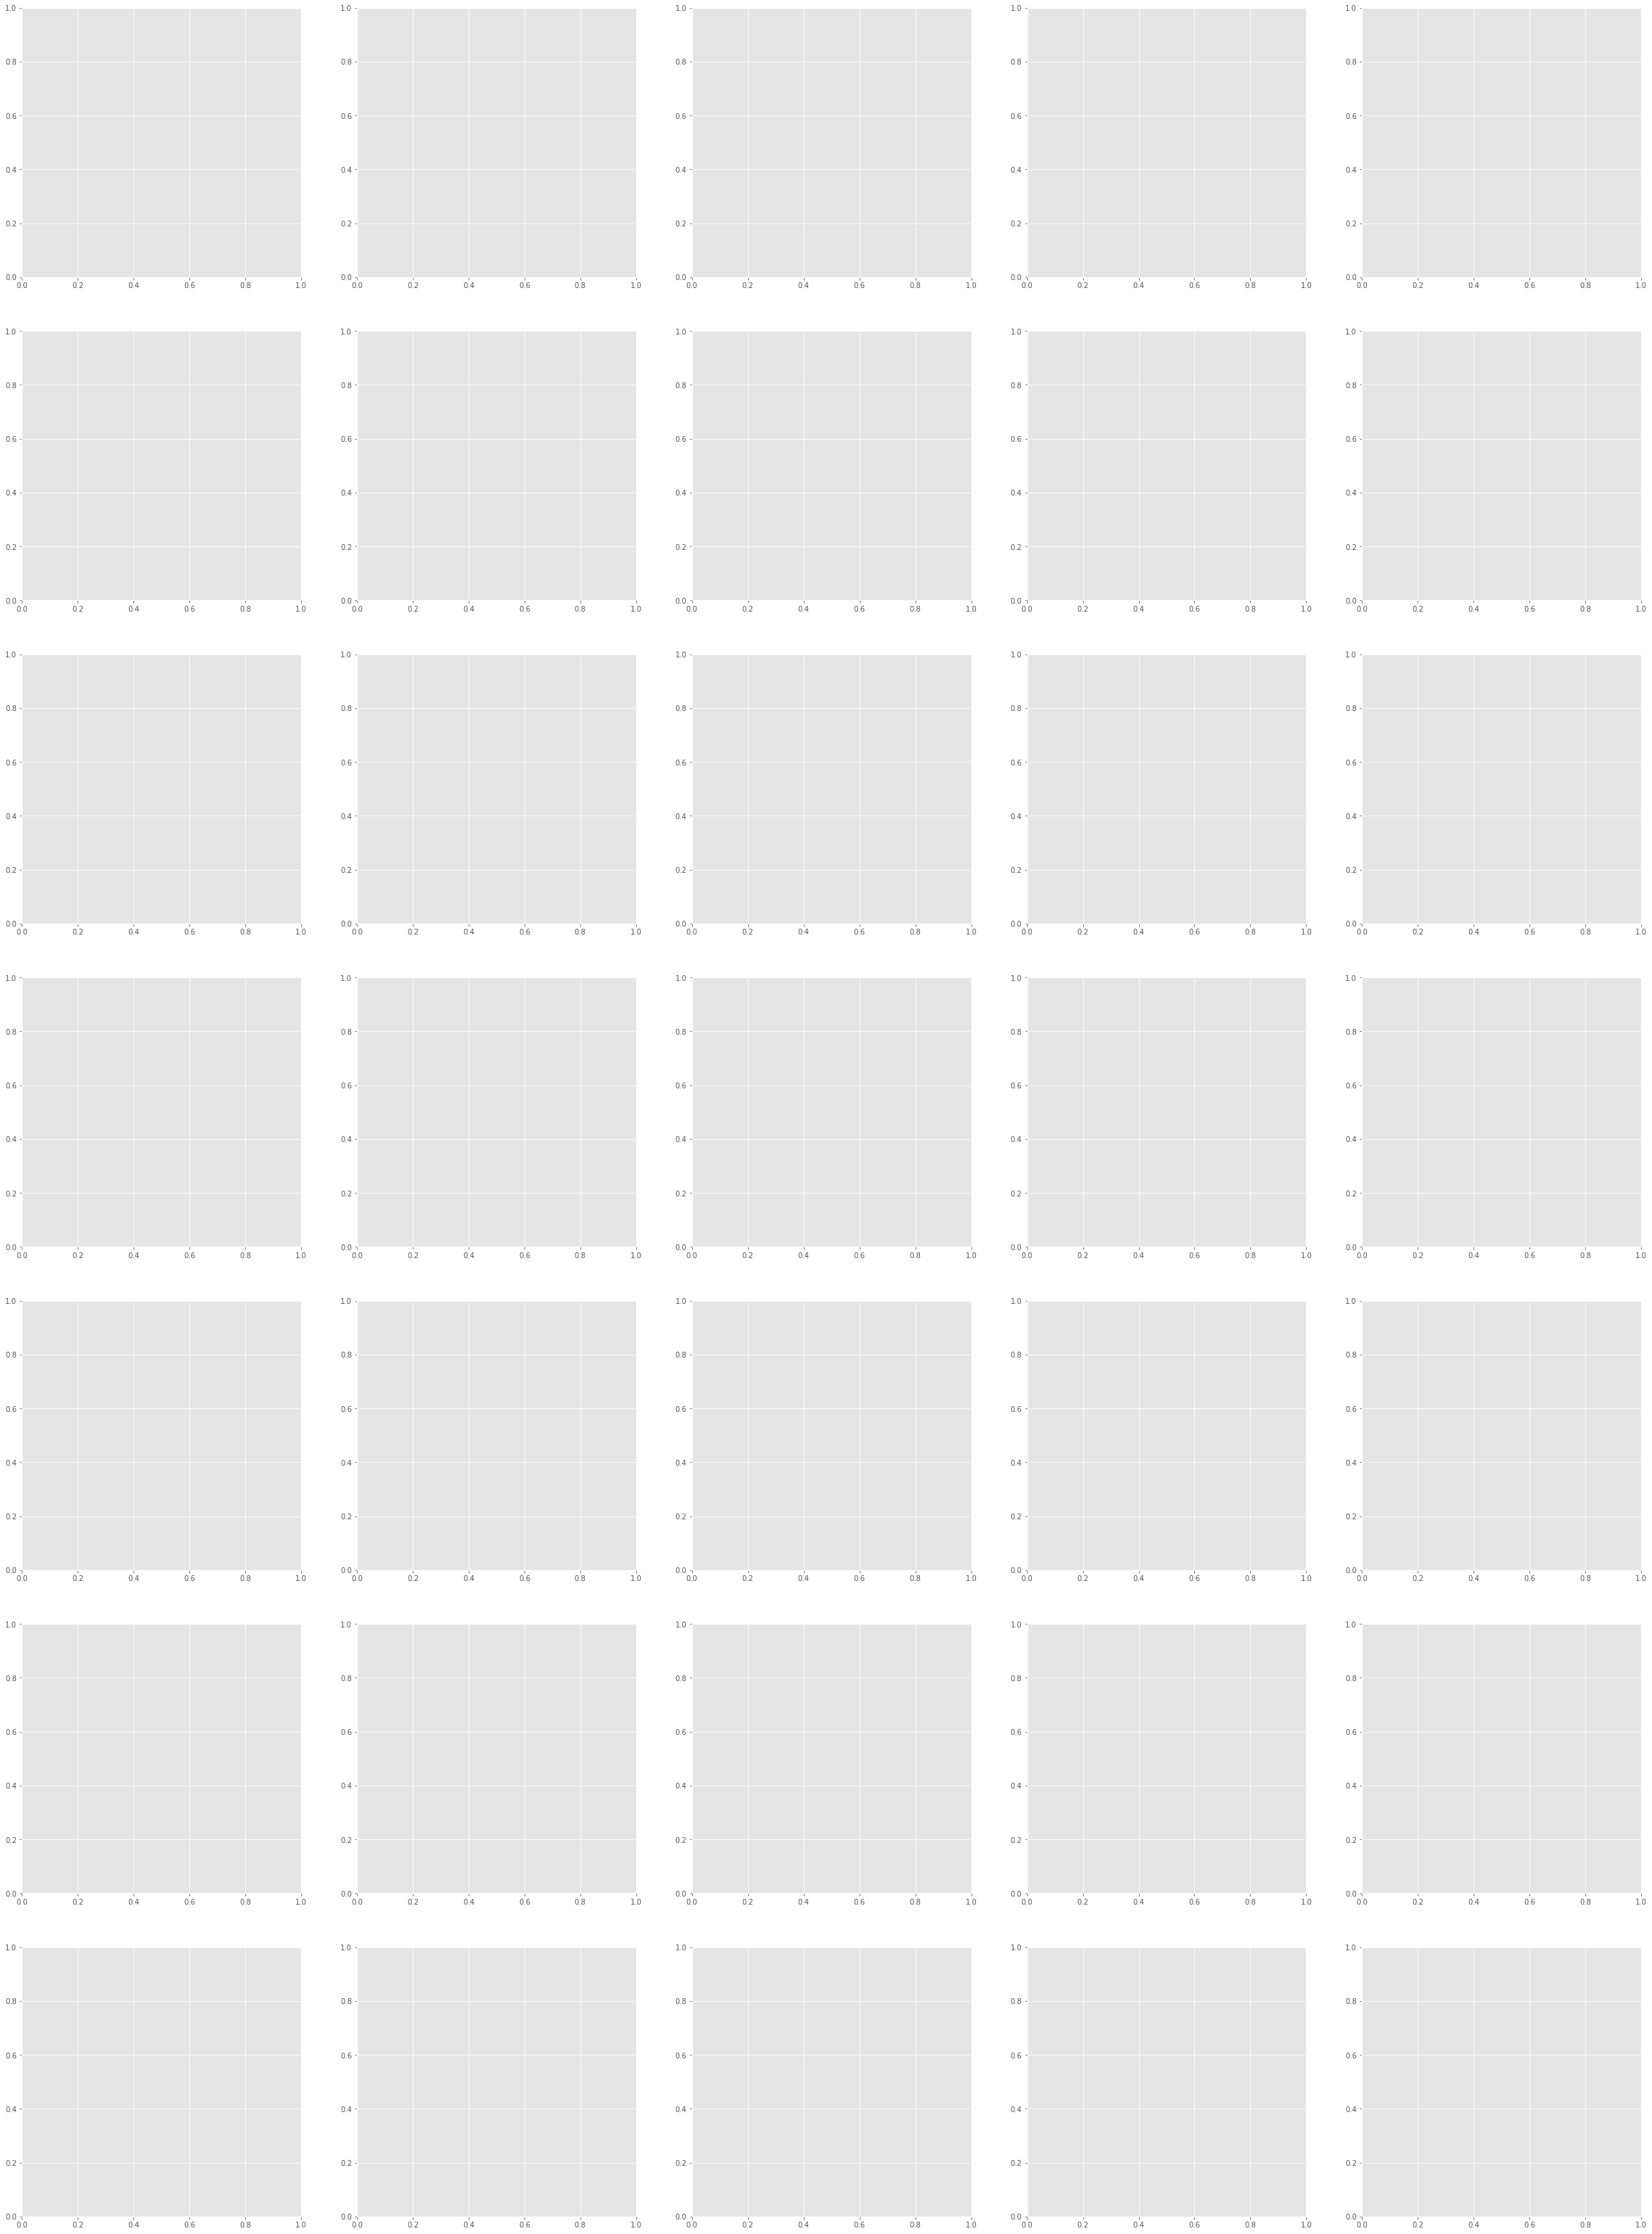

In [28]:
img_size = (512, 512)

last_conv_layer_name = "ResBlock_53"
bat = 2
test_ims, labels = test_set[bat][0], test_set[bat][1]

print(test_ims.shape, labels.shape)

print(f"Visualizing Grad-CAM for batch {bat}.")

predictions = tta_classifier.predict(test_ims)

fig, axes  = plt.subplots((test_ims.shape[0] // 5) + 1, 5, figsize=(5 * 8, (test_ims.shape[0] // 5 + 1) * 8))

for k, (im, l, p, ax) in enumerate(zip(test_ims, labels, predictions, axes.flatten())):
    heatmap = make_gradcam_heatmap(im, tta_classifier, last_conv_layer_name)
    heatmap = (heatmap - heatmap.min(axis=(0, 1))) / (heatmap.max(axis=(0, 1)) - heatmap.min(axis=(0, 1)))
    save_and_display_gradcam(im, heatmap, ax)
    ax.set_title(f"GT: {l}, Pred: {round(p[0], 2)}")